In [1]:
#import statements
from mnist import MNIST
from os.path import expanduser
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import fmin
from sklearn import preprocessing
from matplotlib import rcParams
from sklearn import linear_model
from sklearn.multioutput import MultiOutputRegressor
import matplotlib.ticker as plticker
from matplotlib.patches import Patch
from tqdm.notebook import tqdm
from copy import deepcopy
import math
from matplotlib import gridspec
from PIL import Image
import pandas as pd
import random
import itertools
from scipy import interp
import matplotlib.cm as cm
from sklearn.metrics import *
from sklearn import preprocessing
from sklearn.multiclass import OneVsRestClassifier
from sklearn.utils import resample
from sklearn.model_selection import KFold


In [2]:
#all the functions that are called throughout the rest of the notebook
'''boxPlotter takes in a 4D array X containing cross validated model coefficients for various model fit parameter 
 values (e.g. alpha, or l1 ratio) and plots box plots for the cross validated data for eah coefficient value
 and colors these box plots by which column of x they come from. This serves to indcate not only which model
 coefficients have the highest values, but which of the multiple outputs they contribute to modeling.
 
    INPUTS:
    X: numpy.ndarray of data to analyze. Expected shape is (m,p,c,a) where m is the number of variables modelled,
        p is the number of outputs to regress on, c is the number of cross validation iterations, 
        and a is the number of model fit parameters (e.g. alpha, l1 ratio) varied.
    categoreis: list of scalar values indicating model fit parameters to plot box plots for.
    top_perc: scalar value indicating the percent of largest coefficient values to plot. Default of 1%.
    medianbar: scalar value indicating the line width of the median bar in each box plot. Default of 3.
    fontsize: scalar value indicating the font size for each generated plot. Default of 12.
    figsize: list of two scalar values [w,h] indicating the width (w) and height (h) of each plot. As 
            the number of top coefficients to plot increase the width of the plot should be adjusted
            accordingly. Default is [25, 5].
    class_title: string value that allows control over the title above each plot. Title appears as,
                Top %'+ str(top_perc)+ ' Model Coefficients by Digit Class, ' + class_title + str(categories[i])
    
    OUTPUTS:
    plots: sequence of box plots.
    
    NOTES:
    The color sequece used to discriminate columns of X for each coefficient can discriminate
    up to max of 10 categories.
'''
def boxPlotter(X, categories, top_perc=1.0, medianbar = 3, fontsize = 12, figsize = [25, 5], class_title='Var = '):
    m = X.shape[0]
    p = X.shape[1]
    multiple = len(categories) > 1
    for i in tqdm(range(0, len(categories))):
        if multiple:
            x = np.average(X[:,:,:,i], axis=2)
        else:
            x = np.average(X[:,:,:], axis=2)
        xflat = x.flatten()
        top = int(((m*p)*(top_perc/100)))
        ind = np.argpartition(xflat, -top, axis=0)[-top:]
        ind_sort = ind[np.argsort(xflat[ind])[::-1]]
        (pix, dig) = np.unravel_index(ind_sort, (m,p))
        if multiple:
            data = X[:,:,:,i][pix,dig,:]
        else:
            data = X[:,:,:][pix,dig,:]

        plt.rcParams['figure.figsize'] = figsize
        rcParams.update({'font.size': fontsize})
        medianprops = dict(linestyle='-.', linewidth=medianbar)
        fig, ax = plt.subplots()

        cols = []
        legend_elements = []

        for j in range(0, len(ind)):
            bp = ax.boxplot(data[j].T, positions = [j], medianprops=medianprops, patch_artist=True)
            color = 'C' + str(dig[j])

            for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
                plt.setp(bp[element], color=color)
            for patch in bp['boxes']:
                patch.set(facecolor=color)

            if dig[j] not in cols:
                cols.append(dig[j])


        col_array = np.array(cols)
        cols_sorted = col_array[np.argsort(col_array)]
        for c in cols_sorted:
            color = 'C' + str(c)
            legend_elements.append(Patch(facecolor=color, edgecolor=color, label='coeff col ' + str(c)))

        ax.legend(handles=legend_elements, loc='best')
        ax.set_xticklabels(pix)
        ax.set_title('Top %'+ str(top_perc)+ ' Model Coefficients by Digit Class, ' + class_title + str(categories[i]) )



"""
This function prints and plots the confusion matrix.
Normalization can be applied by setting `normalize=True`.
Adapted from code at: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
"""
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    bottom, top = plt.ylim() 
    #plt.ylim(bottom + 0.5, top - 0.5)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
'''Takes in a one hot encoded array where each column is a different class, and returns a 1D array with
the class value for each row represented by the index of the 1 hot encoding in that row.'''
def class_decoder(b):
    rows = b.shape[0]
    cols = b.shape[1]
    decoded = []
    for i in range(0, rows):
        maxValue = 0
        maxInd = 0
        for j in range(0, cols):
            if b[i, j] > maxValue:
                maxValue = b[i, j]
                maxInd = j
        decoded.append(maxInd)
    return decoded

'''Takes in an array of model coefficients finds the top terms up to the number of terms indicated (num_terms), keeps
those values, and zeros out the rest of the coefficient values. This allows for testing of model sparsity. If X is 3D
the third axis is interpreted as cross validated coefficient values. The coefficient to compare to find maximal
values is the average of coefficients across cross validation. The CV data should be along the 3rd data axis.'''
def zero_out(X, num_terms):
    dims = X.shape
    if len(dims) > 2:
        x = np.average(X, axis=2)
    else:
        x = X
    xflat = x.flatten()
    ind = np.argpartition(xflat,-(int(num_terms)))[-(int(num_terms)):]
    ind_sort = ind[np.argsort(xflat[ind])[::-1]]
    mask = np.zeros(len(xflat))
    mask[ind_sort] = 1
    xflat_z = xflat*mask
    x_zeroed = np.reshape(xflat_z, dims)
    return x_zeroed

In [3]:
#Importing the MNIST hand written digit data obtained from http://yann.lecun.com/exdb/mnist/
file = '/Documents/AMATH Masters/AMATH563/HW1/dataset/MNIST'
home = expanduser("~") + file
mnist = MNIST(home)
x_train_raw, y_train_raw = mnist.load_training() #60000 samples
x_test_raw, y_test_raw = mnist.load_testing()    #10000 samples

#convert lists to numpy arrays
x_train = np.asarray(x_train_raw) #60000 x 784 where 784 is flattened 28x28 pixel data
y_train = np.asarray(y_train_raw) #60000 x 1 where each entry is the digit class
x_test = np.asarray(x_test_raw) #60000 x 784 where 784 is flattened 28x28 pixel data
y_test = np.asarray(y_test_raw) #60000 x 1 where each entry is the digit class

#label binarize the class arrays, i.e. each column reprents a digit class 
#with binary values representing whether or not the specific image is of that digit class
lb = preprocessing.LabelBinarizer()
lb.fit(y_train)
y_train = lb.transform(y_train)# 60000 x 10 where ach column is a digit class (0 through 9)

lb = preprocessing.LabelBinarizer()
lb.fit(y_test)
y_test = lb.transform(y_test)# 10000 x 10 where each column is a digit class (0 through 9)

n = x_train.shape[0] #number of images in data set (training set has 60000 flattened images)
m = x_train.shape[1] #number of pixels (28x28 yields 784 pixels total)
p = y_train.shape[1] #number of classes (10 classes, 0 through 9)

A = x_train#hold out data
b = y_train#hold out data classes

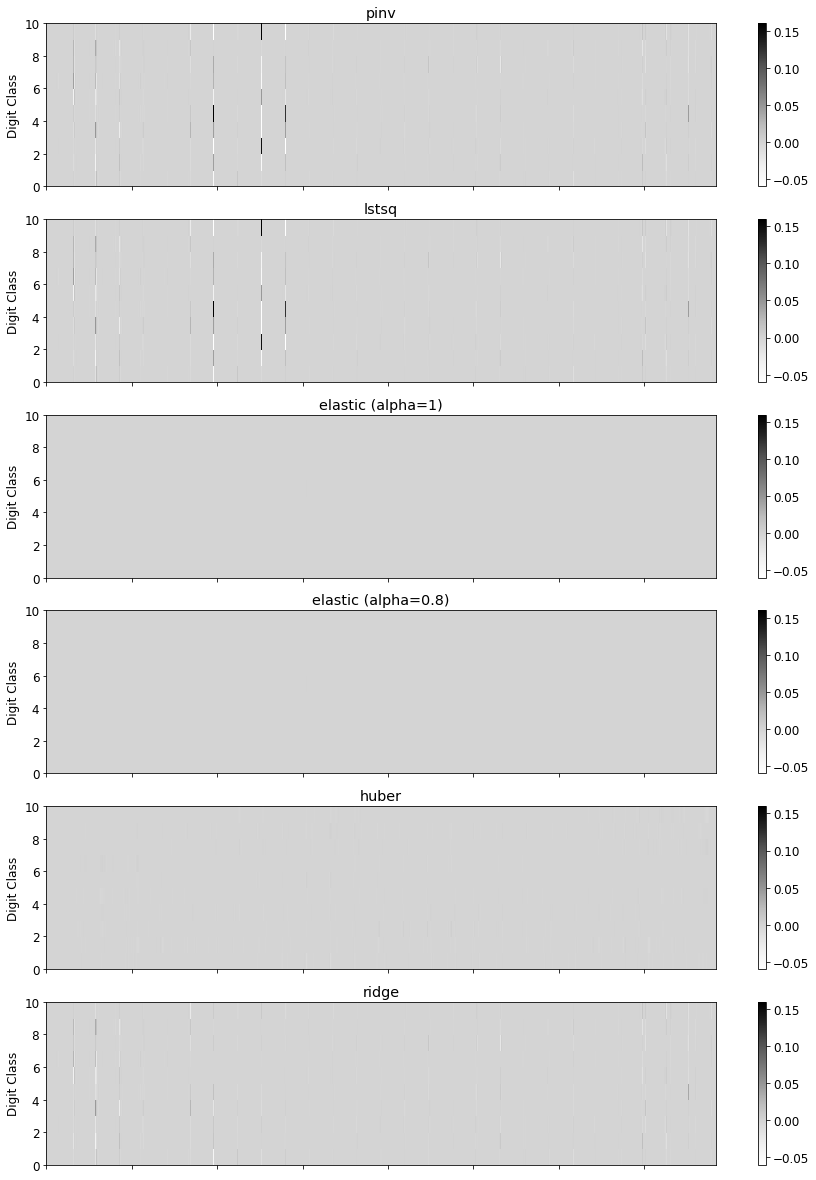

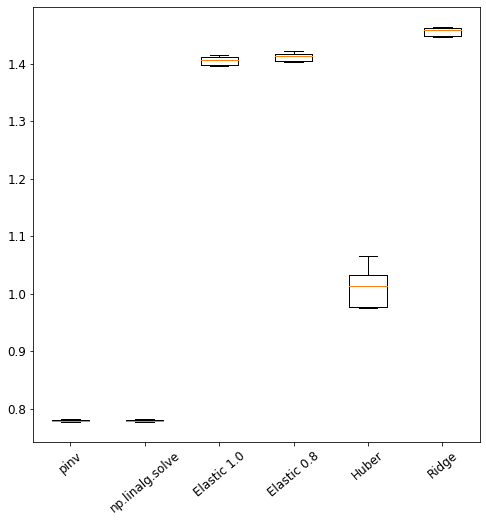

In [4]:
#Begin by investigating different mappings (regularizations) from image space to label space
lam = 0.1#lambda value used in Elastic Net to indicate how much l1 penalty (Lasso) to included relative to l2 (ridge)
cv_folds = 5#number of cross validation folds
kf = KFold(n_splits = cv_folds, random_state = 17, shuffle = True)#initialize KFold for iterative cross validation 

#initialize numpy arrays to hold error values for each cross validation fold
E1 = np.zeros(cv_folds)#pinv errors
E2 = np.zeros(cv_folds)#least squares errors
E3 = np.zeros(cv_folds)#E net alpha 1.0 errors
E4 = np.zeros(cv_folds)#E net alpha 0.8 errors
E5 = np.zeros(cv_folds)#Huber errors
E6 = np.zeros(cv_folds)#Ridge errors

#initialize numpy arrays to hold model coefficients
X1 = np.zeros((m,p,cv_folds))#pinv
X2 = np.zeros((m,p,cv_folds))#least squares
X3 = np.zeros((m,p,cv_folds))#E net alpha 1.0
X4 = np.zeros((m,p,cv_folds))#E net alpha 0.8
X5 = np.zeros((m,p,cv_folds))#Huber errors
X6 = np.zeros((m,p,cv_folds))#Ridge errors

jj = 0#inititalize iterator for storing errors and coefficients for each cross validation fold

#for each subset of training data A fit a model of each type pinv, lstsq, ElasticNet alpha 1.0,
#ElasticNet alpha 0.8, Huber, Ridge
for train_index, test_index in kf.split(A):
    print("Progress {:2.1%}".format(jj / cv_folds), end="\r")#print progress
    
    #pinv solver
    x1 = np.linalg.pinv(A[train_index,:]) @ b[train_index,:]#map from pixel space in test data to test data label space
    b1 = A[train_index,:] @ x1#apply model to data
    E1[jj] = np.linalg.norm(b[train_index,:] - b1,ord=2)/np.linalg.norm(b[train_index,:],ord=2)#calculate error

    x2 = np.linalg.lstsq(A[train_index,:],b[train_index,:],rcond=None)[0]#map from pixel space in test data to test data label space
    b2 = A[train_index,:] @ x2#apply model to data
    E2[jj] = np.linalg.norm(b[train_index,:]-b2,ord=2)/np.linalg.norm(b[train_index,:],ord=2)#calculate error

    regr3 = linear_model.ElasticNet(alpha=1.0, copy_X=True, l1_ratio=lam, max_iter=10**5,random_state=0)
    regr3.fit(A[train_index,:], b[train_index,:])#map from pixel space in test data to test data label space
    x3 = np.transpose(regr3.coef_)#ElasticNet method give coefficients of flipped dimensions
    b3 = A[train_index,:] @ x3#apply model to data
    E3[jj] = np.linalg.norm(b[train_index,:]-b3,ord=2)/np.linalg.norm(b[train_index,:],ord=2)#calculate error

    regr4 = linear_model.ElasticNet(alpha=0.8, copy_X=True, l1_ratio=lam, max_iter=10**5,random_state=0)
    regr4.fit(A[train_index,:], b[train_index,:]) #map from pixel space in test data to test data label space
    x4 = np.transpose(regr4.coef_)#ElasticNet method give coefficients of flipped dimensions
    b4 = A[train_index,:] @ x4#apply model to data
    E4[jj] = np.linalg.norm(b[train_index,:]-b4,ord=2)/np.linalg.norm(b[train_index,:],ord=2)#calculate error

    regr5 = MultiOutputRegressor(linear_model.HuberRegressor(), n_jobs=-1)#using multioutputregressor as huber regressor method does not support multioutput
    huber = regr5.fit(A[train_index,:], b[train_index,:])#map from pixel space in test data to test data label space

    x5 = np.empty([m, p])#initialize empty numpy array to hold the huber coefficients
    #iterate over each estimator for each of the multiple outputs
    for i in range(0, len(huber.estimators_)):
        x5[:, i] = huber.estimators_[i].coef_#grab each estimator's coefficients and fill in column of X

    b5 = A[train_index,:] @ x5#apply model to data
    E5[jj] = np.linalg.norm(b[train_index,:]-b5,ord=2)/np.linalg.norm(b[train_index,:],ord=2)#calculate error

    ridge = linear_model.Ridge(alpha=1.0).fit(A[train_index,:],b[train_index,:])#map from pixel space in test data to test data label space
    x6 = np.transpose(ridge.coef_)#Ridge method returns coefficient array with flipped dimensions
    b6 = A[train_index,:] @ x6#apply model to data
    E6[jj] = np.linalg.norm(b[train_index,:] - b6,ord=2)/np.linalg.norm(b[train_index,:],ord=2)#calculate error
    
    X1[:,:,jj] = x1#pinv coefficients
    X2[:,:,jj] = x2#least squares coefficients
    X3[:,:,jj] = x3#ElasticNet alpha=1.0 coefficients
    X4[:,:,jj] = x4#ElasticNet alpha=0.8 coefficients
    X5[:,:,jj] = x5#Huber (Robust) coefficients
    X6[:,:,jj] = x6#Ridge coefficients
    
    jj = jj + 1#iterate so that the errors and coefficients from the next cross fold can be stored

    
Err = np.column_stack((E1,E2,E3,E4,E5,E6))#concatenate all errors together for plotting

reg_styles = ['pinv', 'lstsq', 'elastic (alpha=1)', 'elastic (alpha=0.8)', 'huber', 'ridge']#types of Ax=b solvers used
Xdict = [X1, X2, X3, X4, X5, X6]#list of model coefficients for plotting

#create heat map of coefficient values for each solver
plt.rcParams['figure.figsize'] = [15, 21]
rcParams.update({'font.size': 12})
fig,axs = plt.subplots(len(reg_styles),1, sharex=True)
axs = axs.reshape(-1)
#iterate over solver types and make a subplot heat map
for j in range(0, len(reg_styles)):
    x = np.average(Xdict[j], axis=2)#average across cross validated coefficient values
    x_pcolor = axs[j].pcolor(x.T,cmap='Greys', vmin=-0.06, vmax=0.16)
    fig.colorbar(x_pcolor, ax=axs[j])
    axs[j].set_ylabel('Digit Class')
    axs[j].set_title(reg_styles[j])
    plt.setp(axs[j].get_xticklabels(), visible=False)

#plot k fold cross validated errors for each solver type
plt.rcParams['figure.figsize'] = [8, 8]
plt.figure()
plt.boxplot(Err)
plt.xticks([1, 2, 3, 4, 5, 6], ['pinv', 'np.linalg.solve', 'Elastic 1.0', 'Elastic 0.8', 'Huber', 'Ridge'], rotation=40)
plt.show()

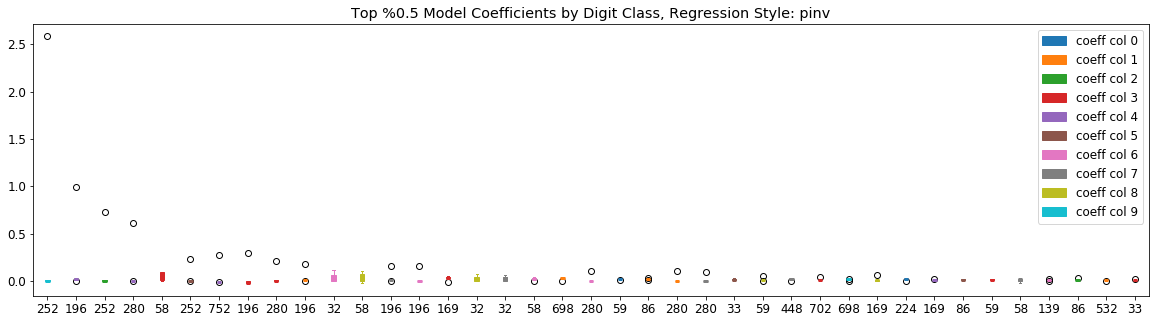

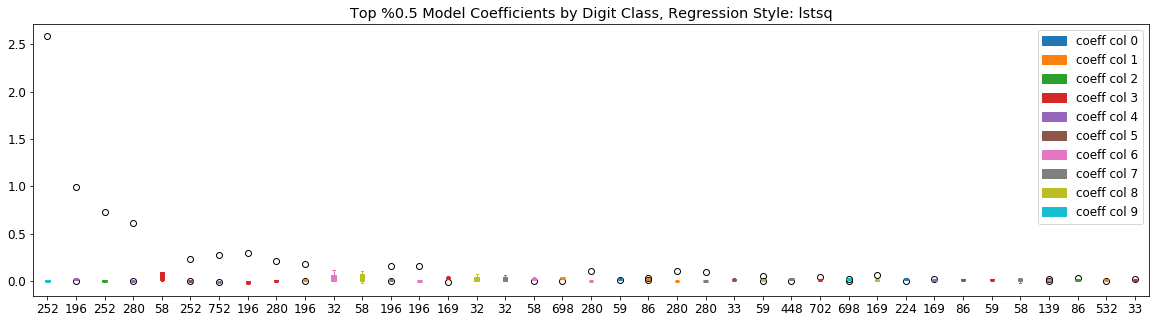

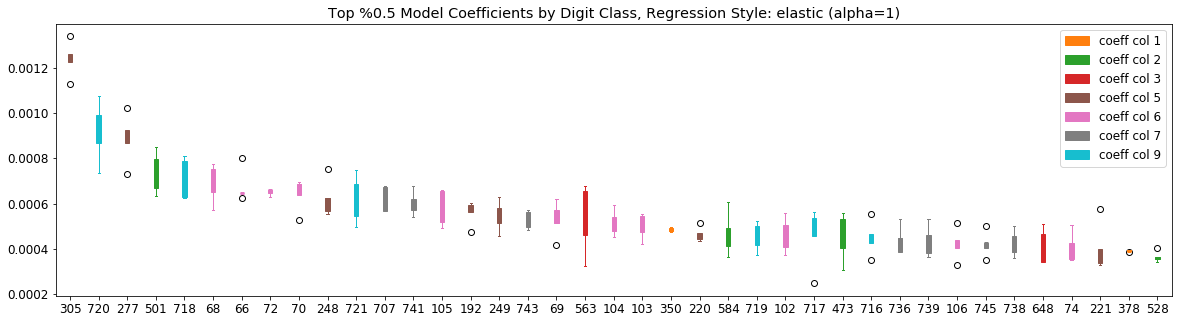

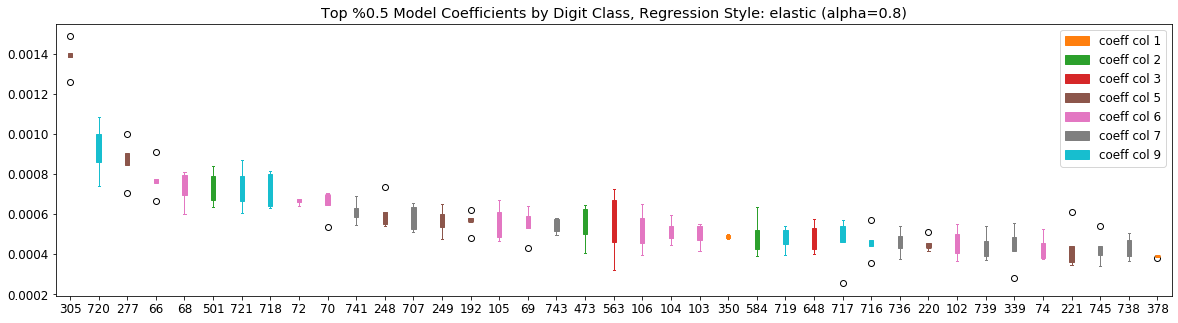

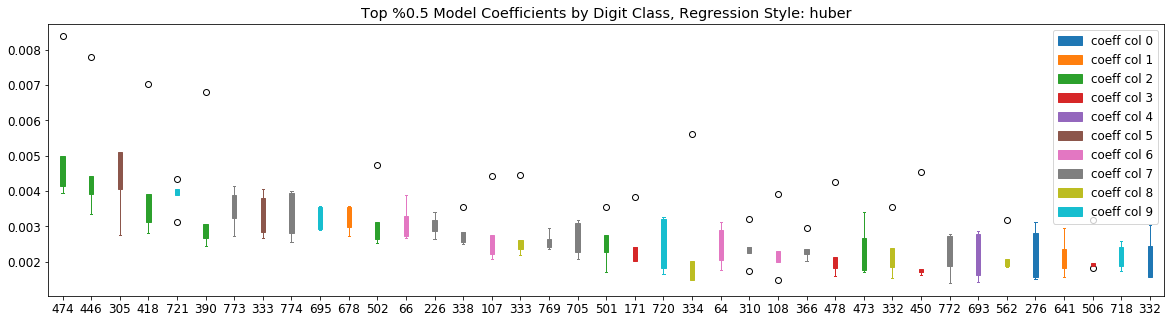

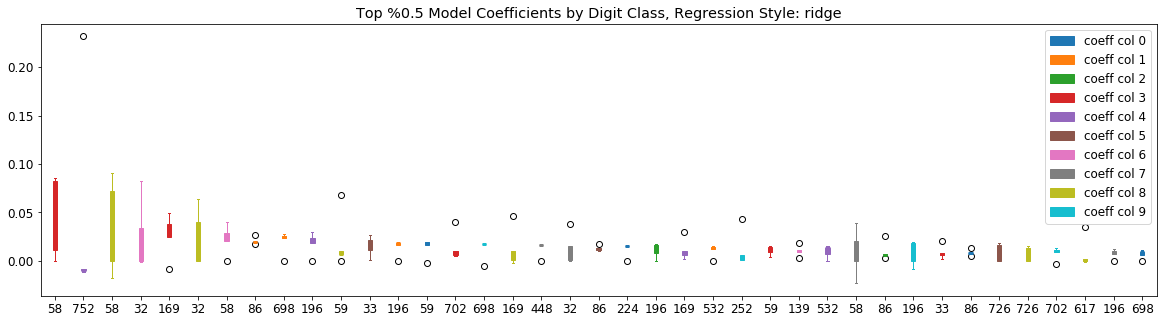

In [5]:
top_perc = 0.5 #top percent of coefficients to extract and plot
Xdict4D = np.transpose(np.array(Xdict), (1, 2, 3, 0))#change Xdict from list of 3D arrays to 4D array

boxPlotter(Xdict4D, reg_styles, top_perc=0.5, medianbar=3, fontsize=12, figsize=[20, 5], class_title='Regression Style: ')

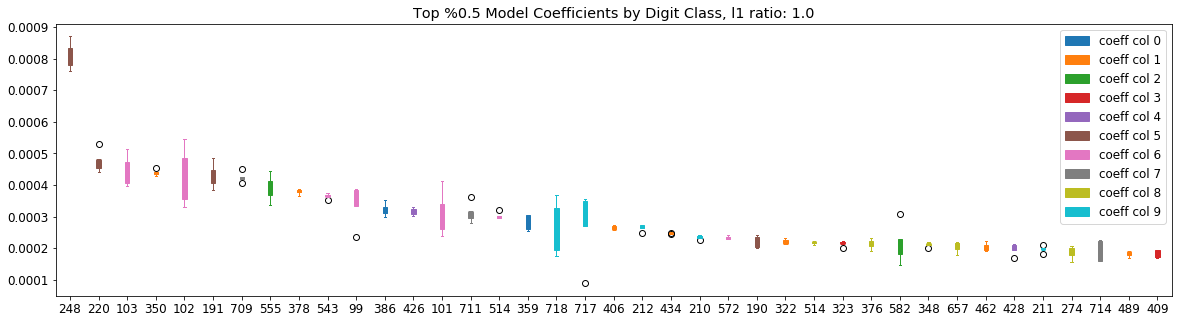

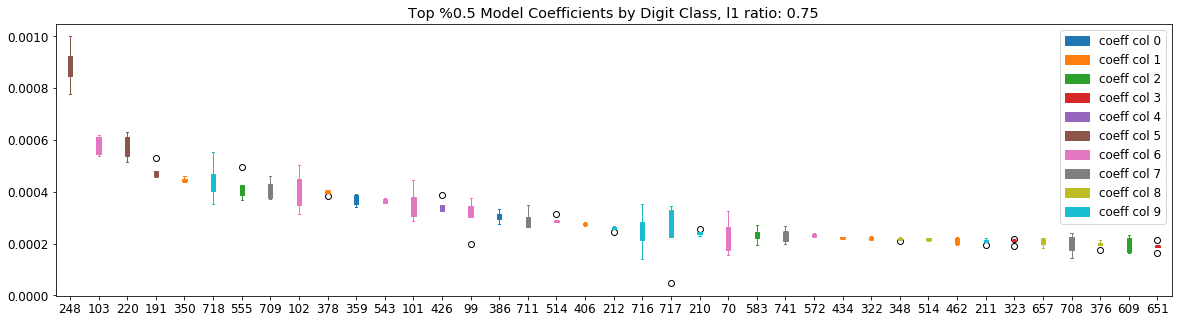

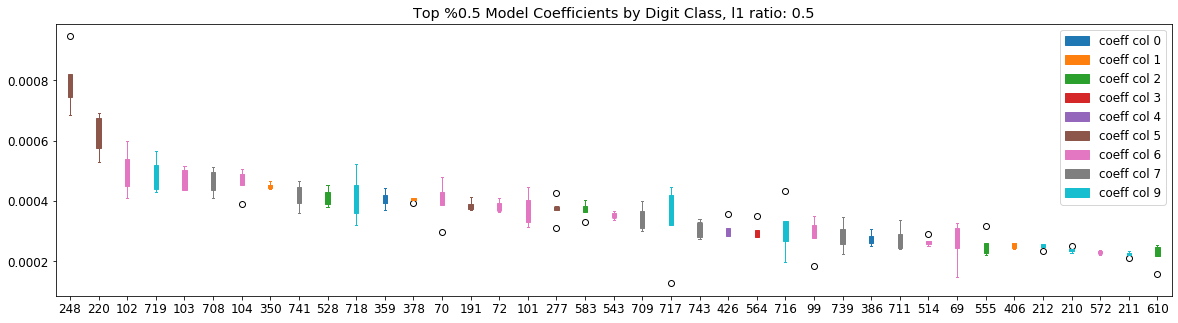

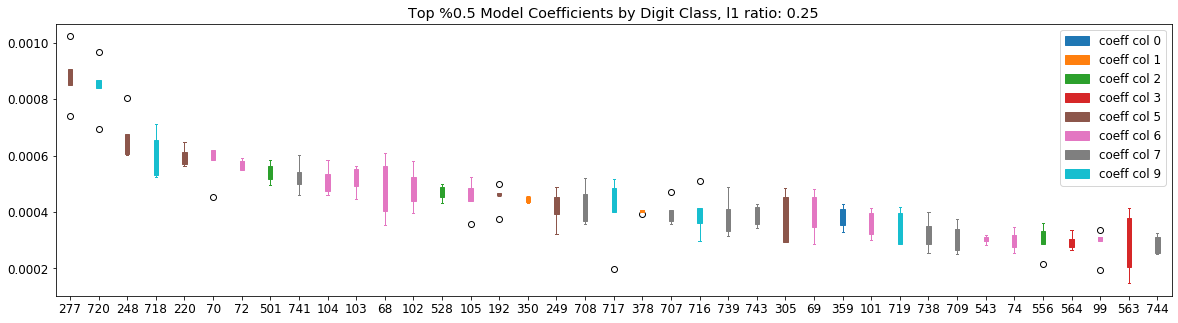

In [7]:
#Work with elastic net to test out different l1_ratios to promote sparsity
cv_folds = 5#number of cross validation folds
kf = KFold(n_splits = cv_folds, random_state = 17, shuffle = True)#initialize K fold
l1_ratios = [1.0, 0.75, 0.5, 0.25]#list of l1 ratios to try (1.0 = Lasso, 0.25 = Mostly Ridge)
Esparse = np.zeros((cv_folds, len(l1_ratios)))#initialize numpy array to store errors
Xsparse = np.zeros((m,p,cv_folds,len(l1_ratios)))#initialize numpy array to store model coefficients

i = 0#initialize iterator to allow for errors and coefficients to be stored for each cross validation fold
#for each subset of training and test data in A, fit a model with a different l1_ratio
for train_index, test_index in kf.split(A):
    print("Progress {:2.1%}".format(i / cv_folds), end="\r")#print progress of paint can position acquisition
    #fit models with different l1_ratios
    for j in range(0, len(l1_ratios)):
        regr_sparse = linear_model.ElasticNet(alpha=1.0, copy_X=True, l1_ratio=l1_ratios[j], max_iter=10**5,random_state=0)
        regr_sparse.fit(A[train_index,:], b[train_index,:])#map from pixel space in test data to test data label space
        xsparse = np.transpose(regr_sparse.coef_)#ElasticNet method give coefficients of flipped dimensions
        bsparse = A[train_index,:] @ xsparse#apply model to data
        Esparse[i, j] = np.linalg.norm(b[train_index,:]-bsparse,ord=2)/np.linalg.norm(b[train_index,:],ord=2)#calculate error
        Xsparse[:,:,i,j] = xsparse#store coefficients for cross validation instance per l1_ratio value
    i = i + 1#iterate cross validation counter
        
boxPlotter(Xsparse, l1_ratios, top_perc=0.5, medianbar=3, fontsize=12, figsize=[20, 5], class_title='l1 ratio: ')#plot coefficients

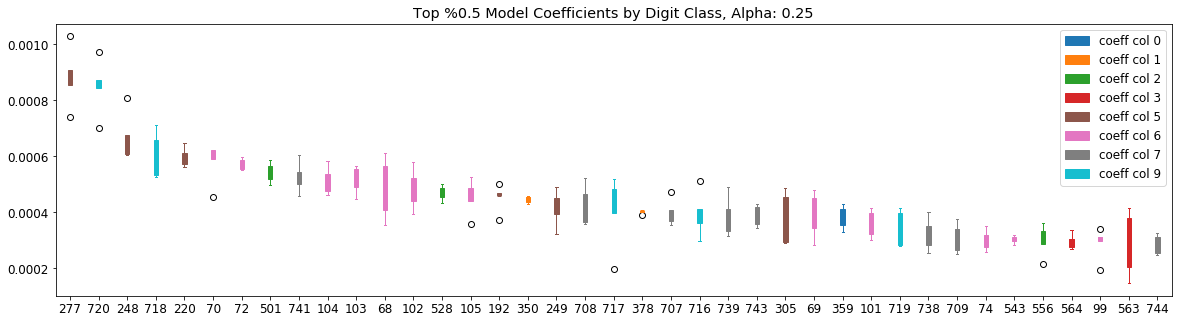

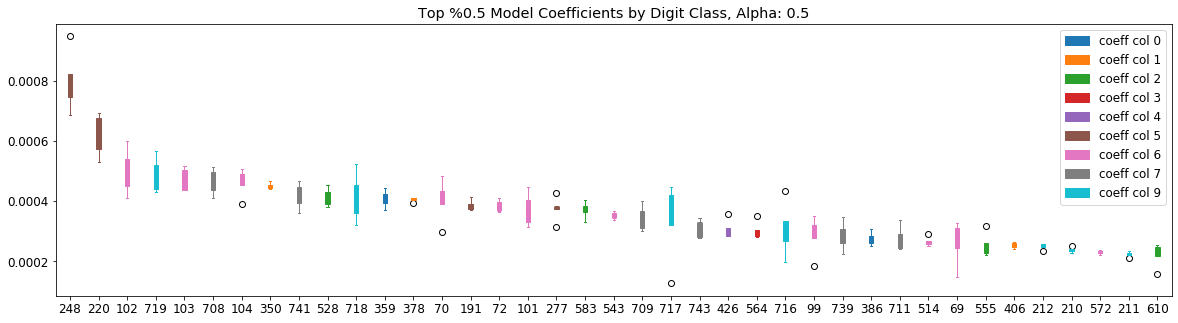

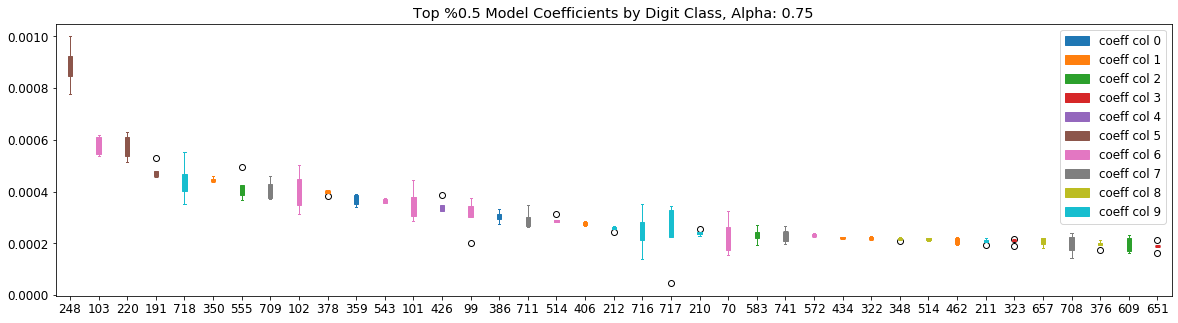

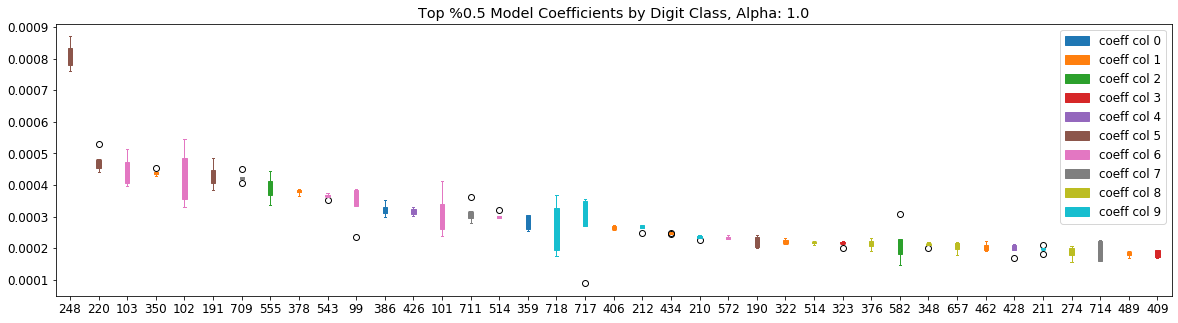

In [11]:
#Work with elastic net to test out different alpha values to promote sparsity
cv_folds = 5#number of cross validation folds
kf = KFold(n_splits = cv_folds, random_state = 17, shuffle = True)#initialize K fold
Elasso = np.zeros((cv_folds, len(l1_ratios)))#initialize numpy array to store errors
Xlasso = np.zeros((m,p,cv_folds,len(l1_ratios)))#initialize numpy array to store model coefficients
alphas = [0.25, 0.5, 0.75, 1.0]#alpha values to test

i = 0#initialize iterator to allow for errors and coefficients to be stored for each cross validation fold
#for each subset of training and test data in A, fit a model with a different alpha. fix l1_ratio=1 (lasso)
for train_index, test_index in kf.split(A):
    print("Progress {:2.1%}".format(i / cv_folds), end="\r")#print progress of paint can position acquisition
    #fit models with different alpha values
    for j in range(0, len(alphas)):
        lasso = linear_model.ElasticNet(alpha=alphas[j], copy_X=True, l1_ratio=1.0, max_iter=10**5,random_state=0)
        lasso.fit(A[train_index,:], b[train_index,:])#map from pixel space in test data to test data label space
        xlasso = np.transpose(lasso.coef_)#ElasticNet method give coefficients of flipped dimensions
        blasso = A[train_index,:] @ xlasso#apply model to data
        Elasso[i, j] = np.linalg.norm(b[train_index,:]-blasso,ord=2)/np.linalg.norm(b[train_index,:],ord=2)#calculate error
        Xlasso[:,:,i,j] = xlasso#store coefficients for cross validation instance per l1_ratio value
    i = i + 1#iterate cross validation counter

boxPlotter(Xlasso, alphas, top_perc=0.5, medianbar=3, fontsize=12, figsize=[20, 5], class_title='Alpha: ')#plot coefficients

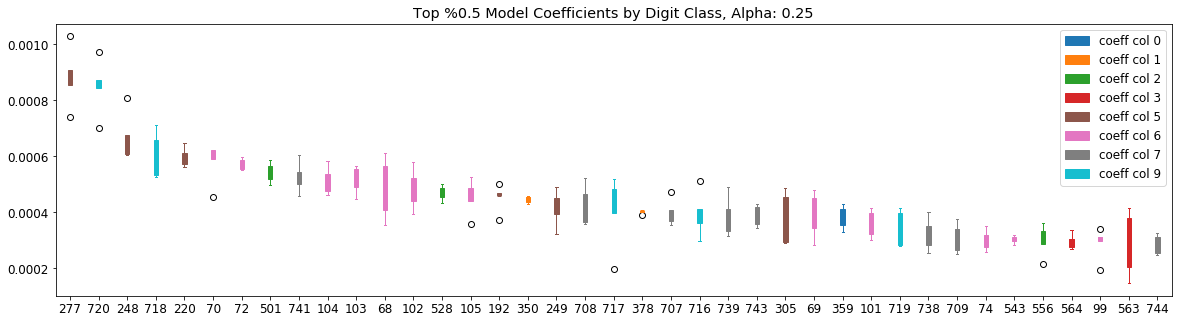

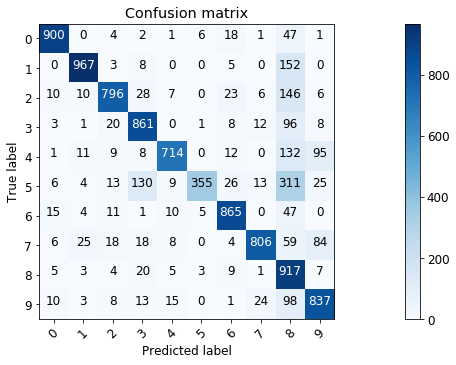

            Results
Accuracy   0.801800
Precision  0.853703
Recall     0.801800
F1         0.806419


In [9]:
#Promote sparsity. Test out the sparsest model: Best l1 ratio appears to be 1.0 and best alpha value 
#appears to be 0.25. Try a model employing both values.
cv_folds = 5#number of cross validation folds
kf = KFold(n_splits = cv_folds, random_state = 17, shuffle = True)#initialize Kfold
l1_ratio = 1.0#l1_ratio value, indicates that Elastic net uses l1 penalty exclusively (lasso)
Elasso_best = np.zeros((cv_folds))#initialize numpy array to store errors
Xlasso_best = np.zeros((m,p,cv_folds))#initialize numpy array to store model coefficients
alpha = 0.25

i = 0#initialize iterator to allow for errors and coefficients to be stored for each cross validation fold
#for each subset of training and test data in A, fit a model
for train_index, test_index in kf.split(A):
    print("Progress {:2.1%}".format(i / cv_folds), end="\r")#print progress
    lasso_best = linear_model.ElasticNet(alpha=alpha, copy_X=True, l1_ratio=l1_ratio, max_iter=10**5,random_state=0)
    lasso_best.fit(A[train_index,:], b[train_index,:])#map from pixel space in test data to test data label space
    xlasso_best = np.transpose(lasso_best.coef_)#ElasticNet method give coefficients of flipped dimensions
    blasso_best = A[train_index,:] @ xlasso_best#apply model to data
    Elasso_best[i] = np.linalg.norm(b[train_index,:]-blasso_best,ord=2)/np.linalg.norm(b[train_index,:],ord=2)#calculate error
    Xlasso_best[:,:,i] = xlasso_best#store coefficient values for each cross validation fold
    i = i + 1#iterate cross validation fold counter

boxPlotter(Xlasso_best, [alpha], top_perc=0.5, medianbar=3, fontsize=12, figsize=[20, 5], class_title='Alpha: ')#plot coefficients of cross validated model (average values)

Atest = x_test#test hold out data for testing cross validated model
btest = y_test#test hold out data labels
classes = np.unique(y_test_raw)#list of numerical digit classes

preds =  Atest @ np.average(Xlasso_best[:,:,:], axis=2)#apply the cross validated model (average coefficients across cv folds) to the hold out data
preds_1D = np. array(class_decoder(preds))#decode the predicted as one hot encoded values and subsequently as digit classes
btest_1D = np. array(class_decoder(btest))#decode the actual one hot encoded values as digit classes

CM = confusion_matrix(btest_1D, preds_1D)# Confusion Matrix
plot_confusion_matrix(CM, classes)#plot of the multiclass confusion matrix

aScore = accuracy_score(btest_1D, preds_1D)#accuracy score
P = precision_score(btest_1D, preds_1D, average='weighted')#precision score
R = recall_score(btest_1D, preds_1D, average='weighted')#recall score
F1 = f1_score(btest_1D, preds_1D, average='weighted')#F1 score
a = {'Results': [aScore, P, R, F1]}#series of evaluation results
aFrame_k = pd.DataFrame(a, index = ['Accuracy', 'Precision', 'Recall', 'F1'])
print(aFrame_k)

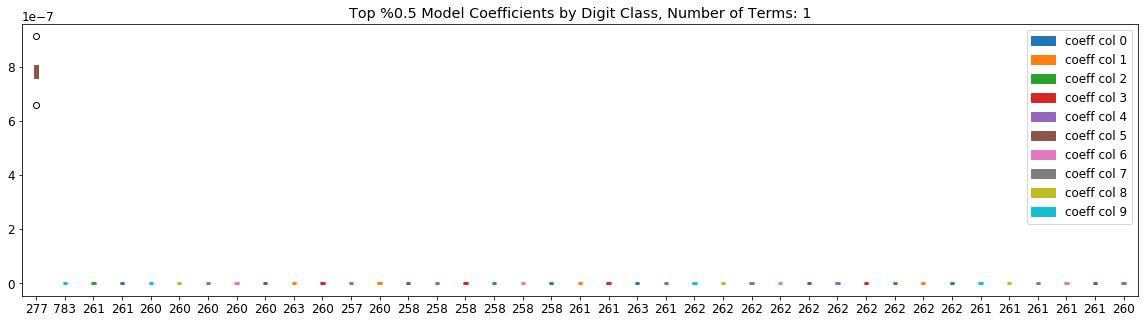

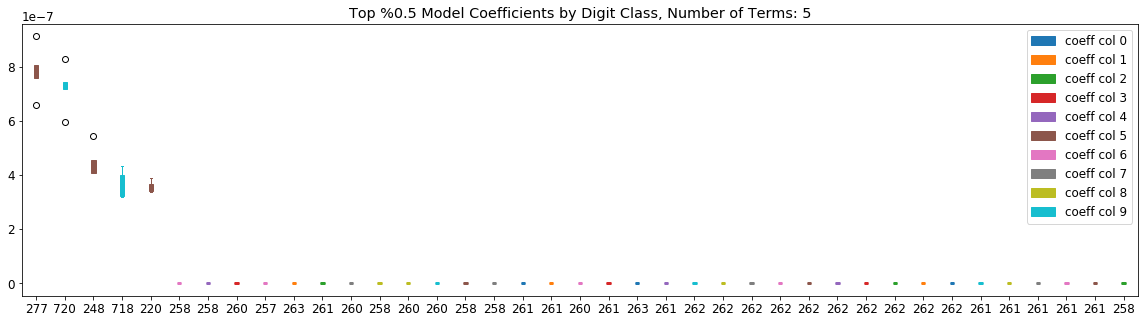

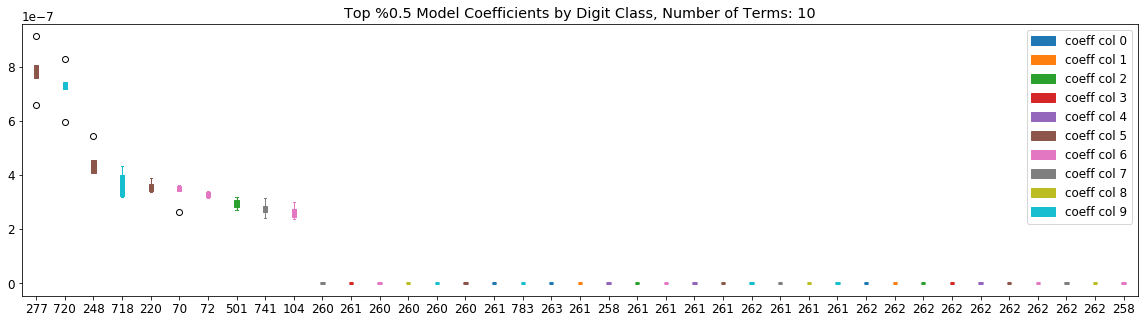

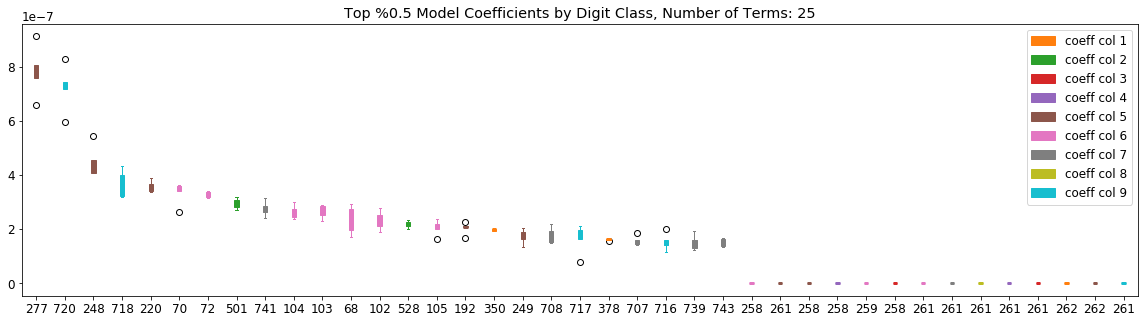

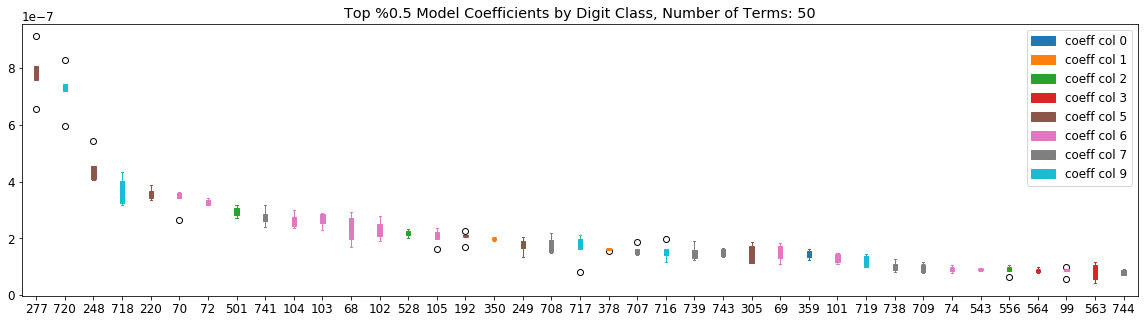

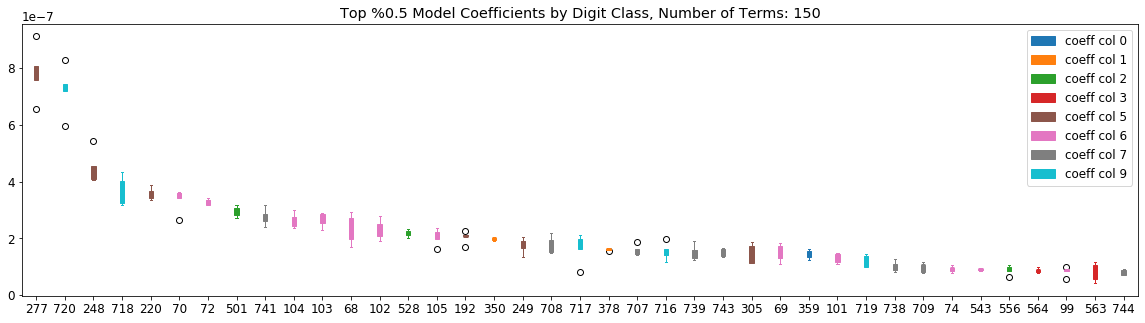

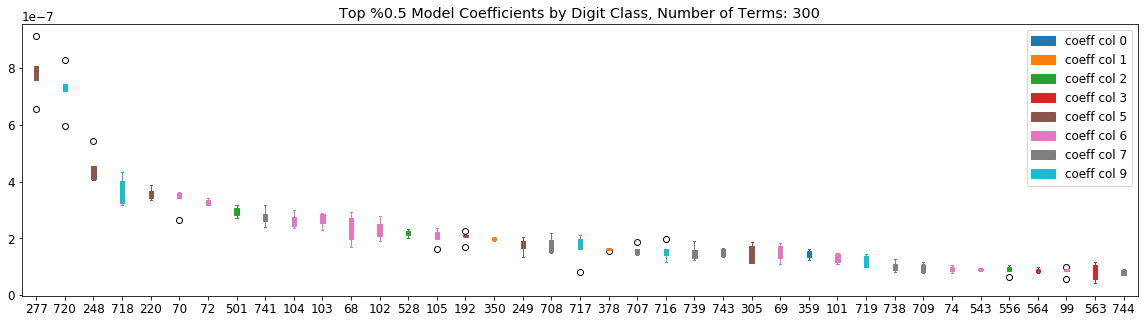

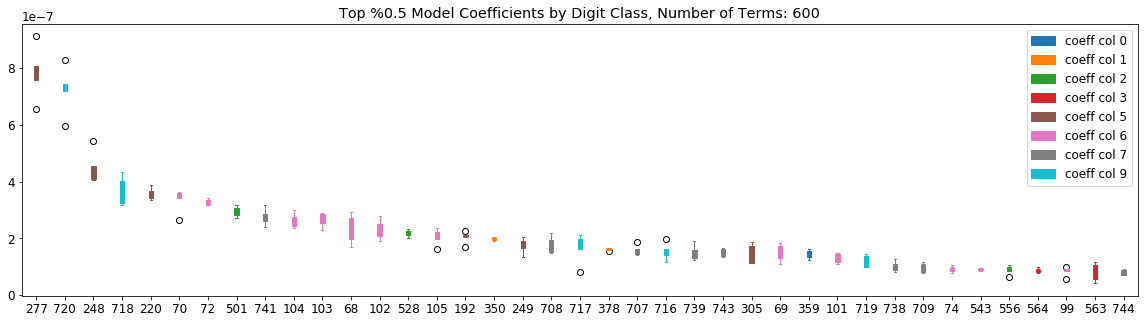

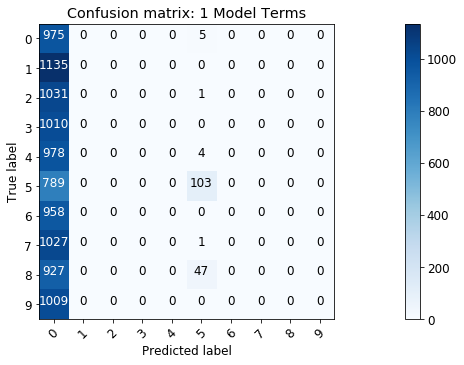

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


            Results
Accuracy   0.107800
Precision  0.066777
Recall     0.107800
F1         0.035114


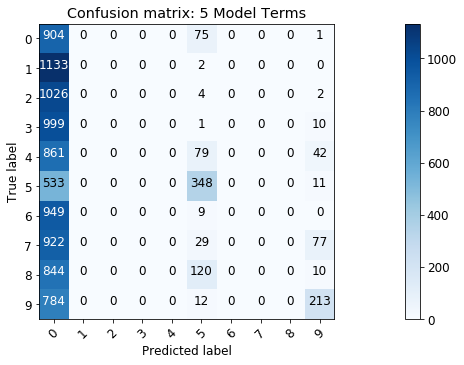

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


            Results
Accuracy   0.146500
Precision  0.114330
Recall     0.146500
F1         0.088613


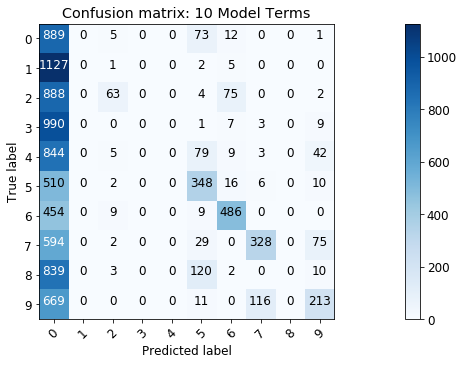

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


            Results
Accuracy   0.232700
Precision  0.338713
Recall     0.232700
F1         0.207125


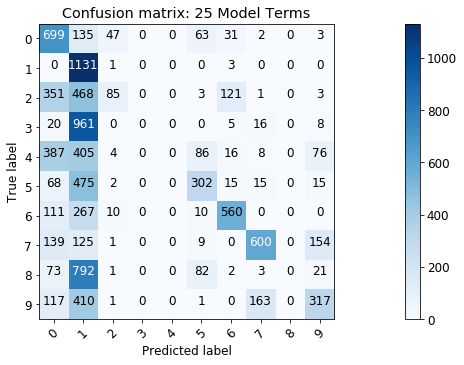

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


            Results
Accuracy   0.369400
Precision  0.367015
Recall     0.369400
F1         0.309004


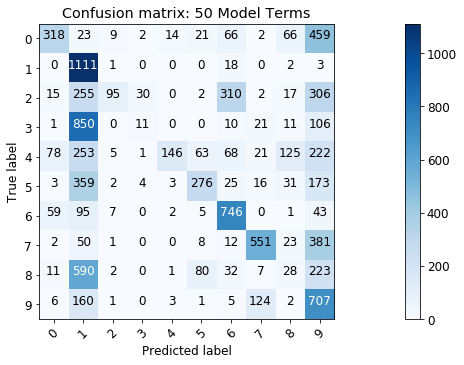

           Results
Accuracy   0.39890
Precision  0.50611
Recall     0.39890
F1         0.34550


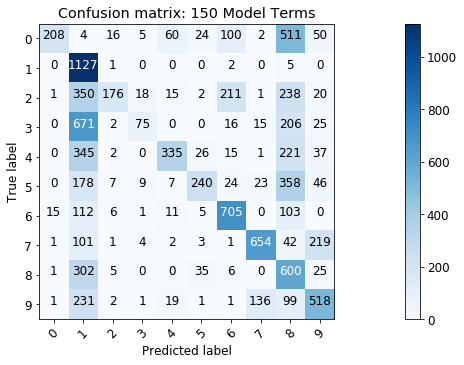

            Results
Accuracy   0.463800
Precision  0.637934
Recall     0.463800
F1         0.440314


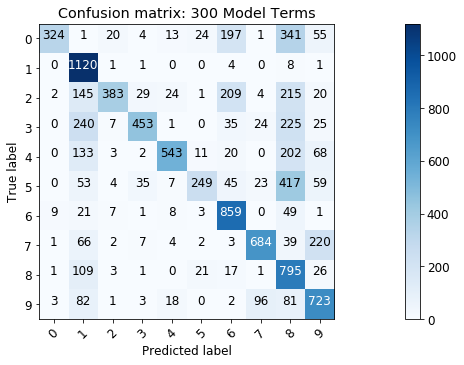

            Results
Accuracy   0.613300
Precision  0.729794
Recall     0.613300
F1         0.604817


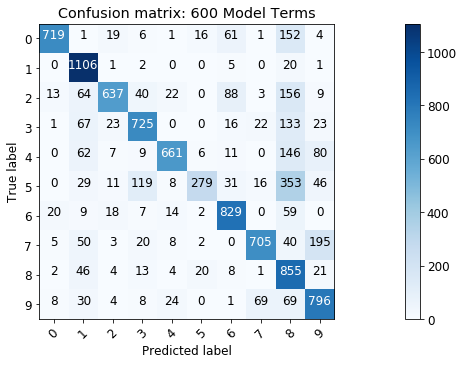

            Results
Accuracy   0.731200
Precision  0.783826
Recall     0.731200
F1         0.730462


In [7]:
#perform analysis for degree of sparsity for best lasso model
cv_folds = 5#number of cross validation folds
num_terms = [1, 5, 10, 25, 50, 150, 300, 600]#list of number of model terms to test
xlasso_bz_plot = np.empty((m, p, cv_folds, len(num_terms)))#initialize numpy array to hold model coefficients
xlasso_bz = np.empty((m, p, len(num_terms)))#initialize numpy array of model terms
for i in range(0, len(num_terms)):

    xlasso_bz[:,:,i] = zero_out(np.average(Xlasso_best[:,:,:], axis=2), num_terms[i])#zero out coefficients for average cv lasso model
    mask = np.ones(xlasso_bz[:,:,i].shape)*xlasso_bz[:,:,i]#create mask with 1s where non-zero coefficients exist
    mask = np.repeat(mask[:, :, np.newaxis], cv_folds, axis=2)#expand mask along 3rd axis so cross validation data remains for coefficient plots
    xlasso_bz_plot[:,:,:,i] = mask*Xlasso_best[:,:,:]#apply mask to the cross validated model coefficients for each number of model terms
    

boxPlotter(xlasso_bz_plot, num_terms, top_perc=0.5, medianbar=3, fontsize=12, figsize=[20, 5], class_title='Number of Terms: ')#plot different number of model terms
Error_dropout = np.empty(len(num_terms))#create array to hold error values for each number of model terms

#iterate over the list of number of model terms included to apply the models of increasing complexity. visualize performance
for i in range(0, len(num_terms)):
    Atest = x_test#test hold out data for testing cross validated model
    btest = y_test#test hold out data labels
    classes = np.unique(y_test_raw)#list of numerical digit classes
    preds =  Atest @ xlasso_bz[:,:,i]#test the model
    preds_1D = np. array(class_decoder(preds))#decode the predicted as one hot encoded values and subsequently as digit classes
    btest_1D = np. array(class_decoder(btest))#decode the actual one hot encoded values as digit classes
    Error_dropout[i] = np.linalg.norm(btest-preds,ord=2)/np.linalg.norm(btest,ord=2)#calculate error
    
    CM = confusion_matrix(btest_1D, preds_1D)# Confusion Matrix
    plot_confusion_matrix(CM, classes, title='Confusion matrix: ' + str(num_terms[i]) + ' Model Terms')#plot of the multiclass confusion matrix


    aScore = accuracy_score(btest_1D, preds_1D)#accuracy score
    P = precision_score(btest_1D, preds_1D, average='weighted')#precision score
    R = recall_score(btest_1D, preds_1D, average='weighted')#recall score
    F1 = f1_score(btest_1D, preds_1D, average='weighted')#F1 score
    a = {'Results': [aScore, P, R, F1]}#series of evaluation results
    aFrame_k = pd.DataFrame(a, index = ['Accuracy', 'Precision', 'Recall', 'F1'])
    print(aFrame_k)


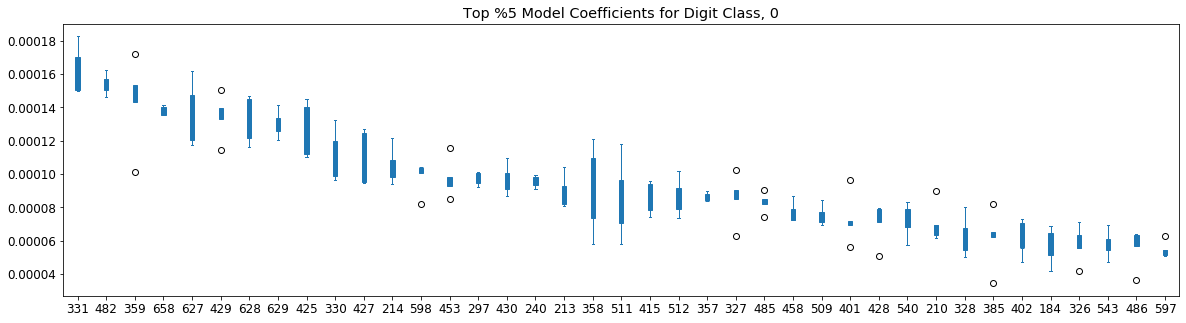

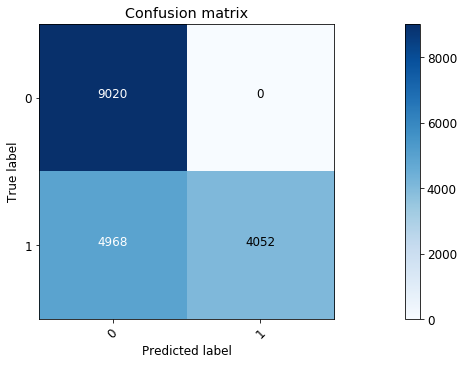

            Results
Accuracy   0.724612
Precision  0.822419
Recall     0.724612
F1         0.702013


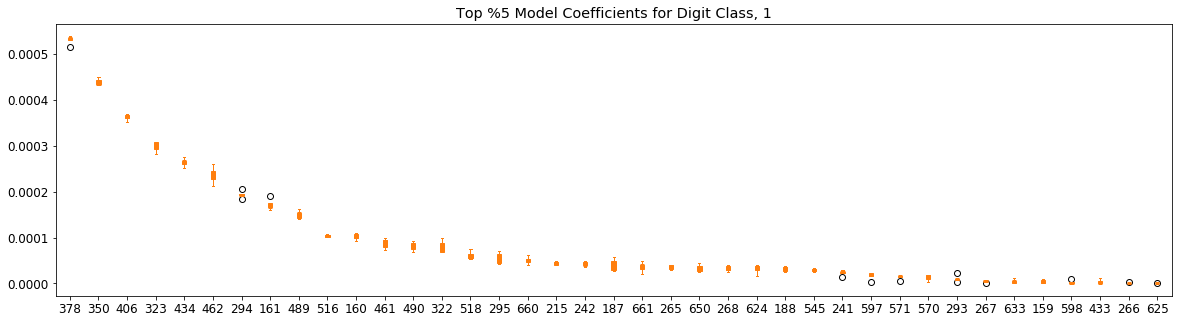

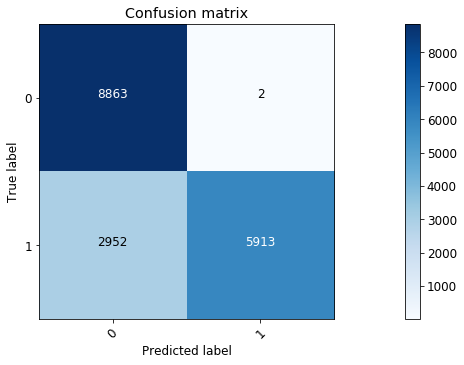

            Results
Accuracy   0.833390
Precision  0.874905
Recall     0.833390
F1         0.828646


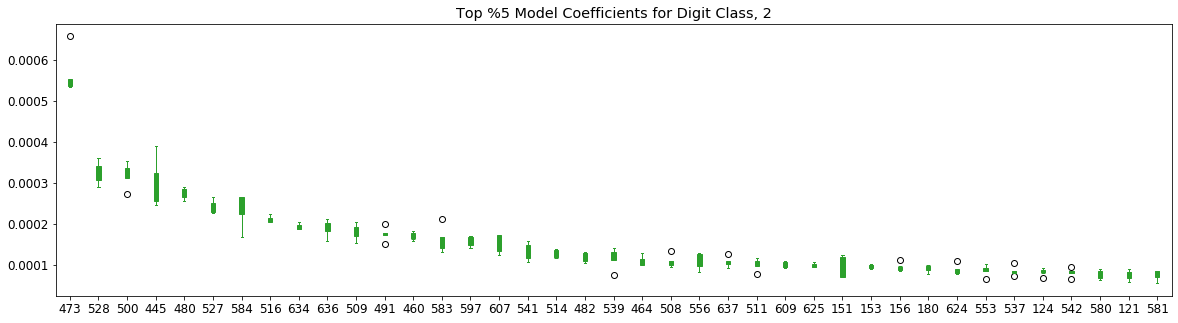

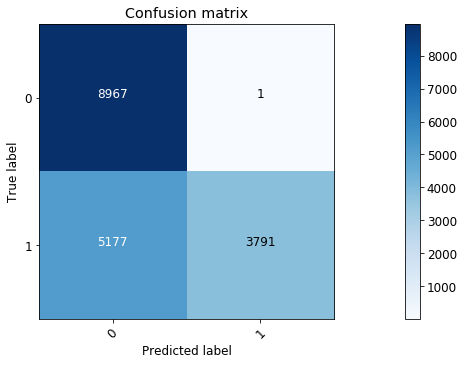

            Results
Accuracy   0.711307
Precision  0.816858
Recall     0.711307
F1         0.685081


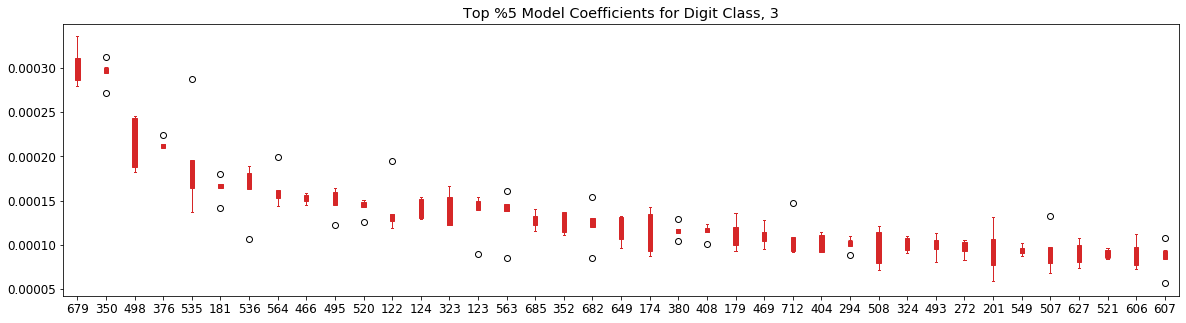

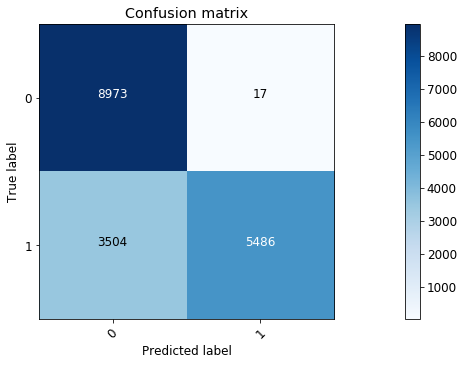

            Results
Accuracy   0.804171
Precision  0.858037
Recall     0.804171
F1         0.796518


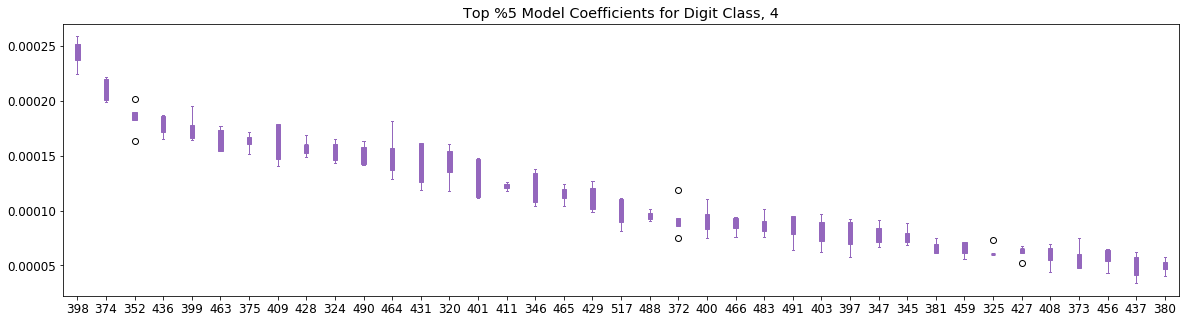

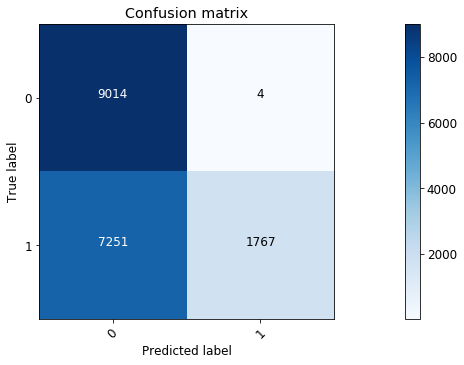

            Results
Accuracy   0.597749
Precision  0.775969
Recall     0.597749
F1         0.520302


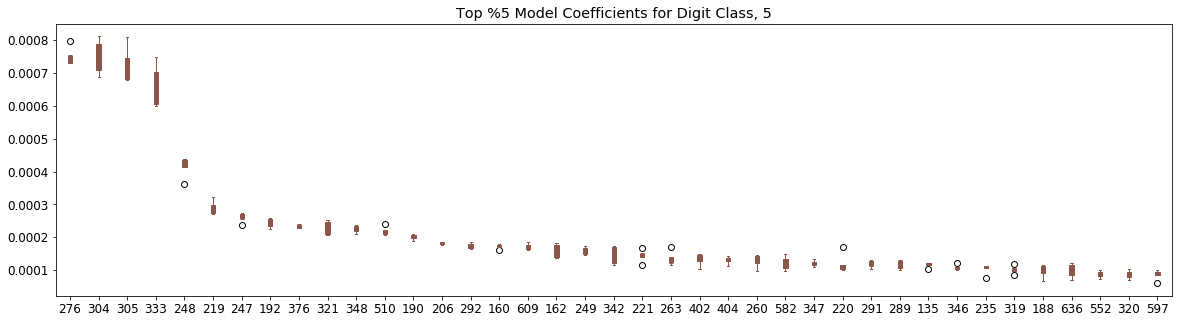

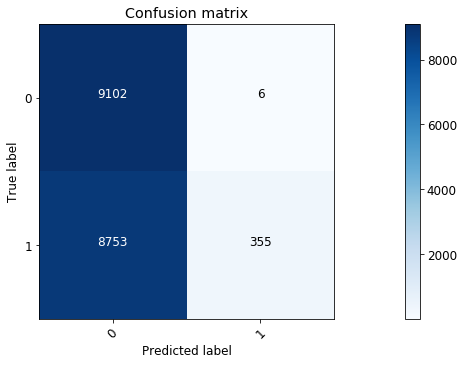

            Results
Accuracy   0.519159
Precision  0.746576
Recall     0.519159
F1         0.375064


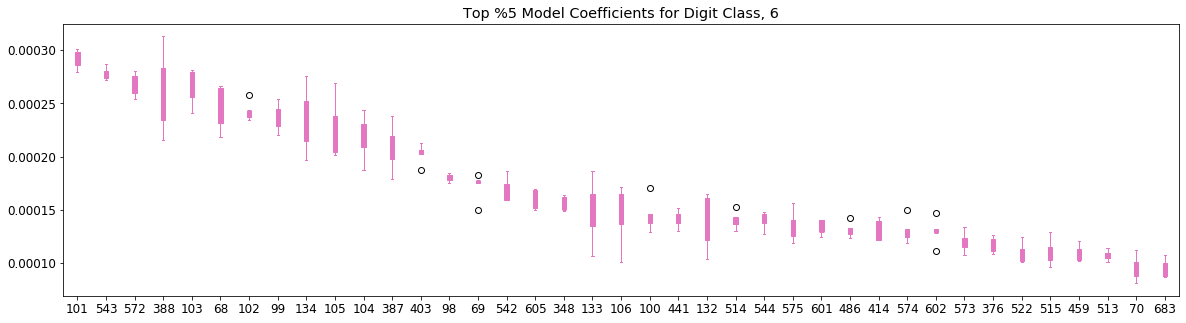

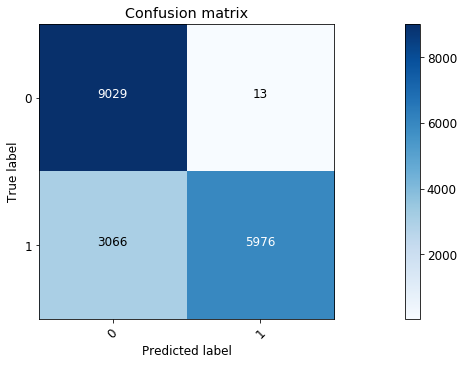

            Results
Accuracy   0.829739
Precision  0.872168
Recall     0.829739
F1         0.824744


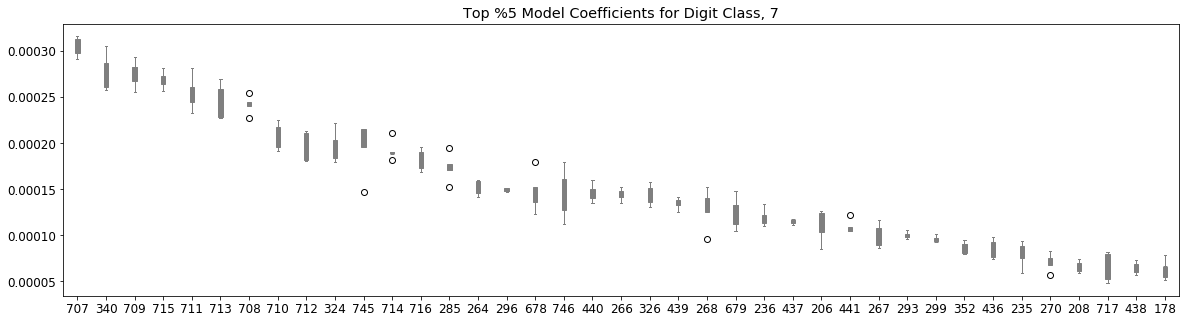

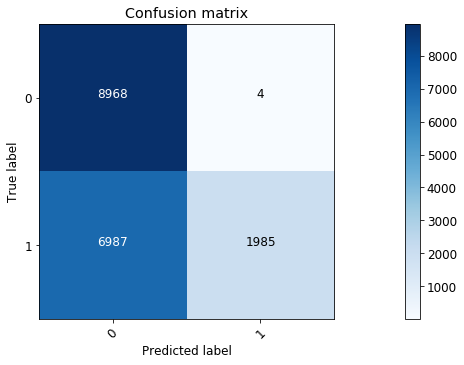

            Results
Accuracy   0.610399
Precision  0.780035
Recall     0.610399
F1         0.540867


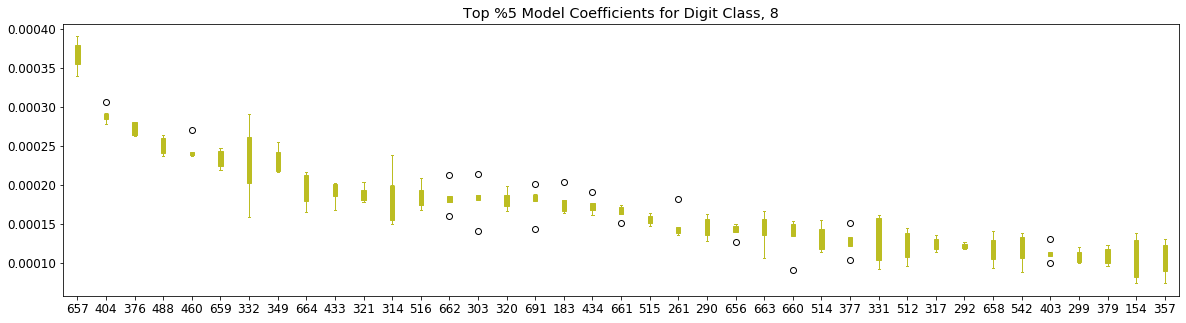

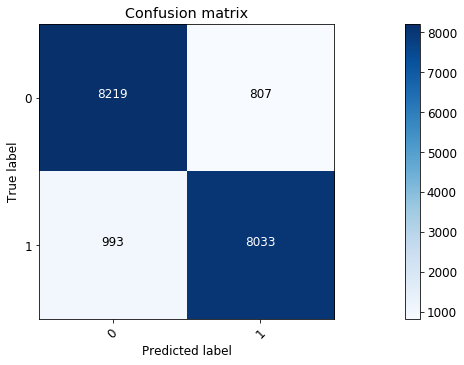

            Results
Accuracy   0.900288
Precision  0.900458
Recall     0.900288
F1         0.900277


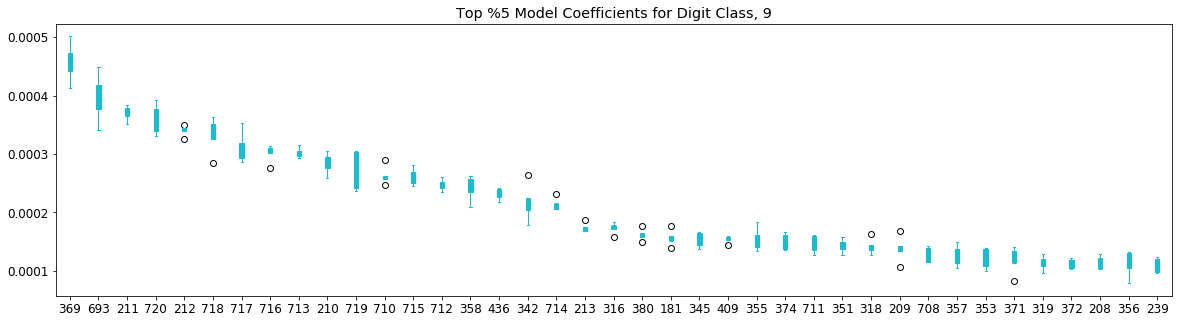

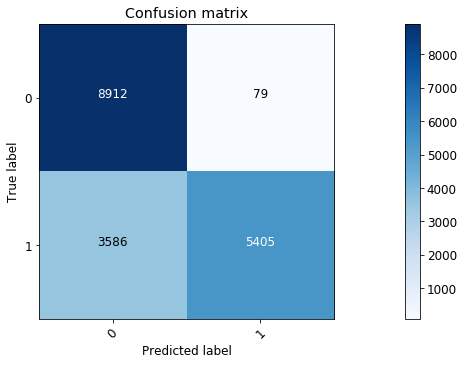

            Results
Accuracy   0.796185
Precision  0.849334
Recall     0.796185
F1         0.788126



In [18]:
#Redo analysis with each digit individually
cv_folds = 5#number of cross validation folds
kf = KFold(n_splits = cv_folds, random_state = 17, shuffle = True)#initialize Kfold
classes = np.unique(y_test_raw)#list of unique hand written numerical digit classes
l1_ratio = 1.0#l1_ratio value, indicates that Elastic net uses l1 penalty exclusively (lasso)
Elasso_dig = np.zeros((len(classes), cv_folds))#initialize numpy array to store errors
Xlasso_dig = np.zeros((m,1,len(classes), cv_folds))#initialize numpy array to store model coefficients
alpha = 0.25#alpha value to use (scales degree of l1 penalty)
top_perc=5#the percentage of top coefficients to plot
medianbar=3#line width of median bar in box plot
fontsize=12#size of font in box plots
figsize=[20, 5]# figure size

#iterate over each digit class
for i in tqdm(range(0, len(classes))):
    #Need to up sample minority digit class to resolve class imbalance problem
    btrain = b[:, i]#training data labels for the digit class will be the corresponding column in B that encodes that digit
    dig_ind = np.where(btrain == 1)[0]#find where the true labels are in B for digit of interest
    other_ind = np.where(btrain == 0)[0]#find where the false labels are in B for digit of interest
    upsampled_b = resample(btrain[dig_ind], replace=True,n_samples=len(other_ind),random_state=123)#upsample the true labels
    upsampled_A = resample(A[dig_ind], replace=True,n_samples=len(other_ind),random_state=123)#upsample the corresponding data for these labels in A
    btrain = np.append(btrain[other_ind], upsampled_b, axis=0)#create new training label set with upsample instances
    Atrain = np.append(A[other_ind,:], upsampled_A, axis=0)#create new training data set with upsample instances
    
    j = 0#initialize cross validation fold counter to allow coefficients and errors to be stored for each iteration
    #for each subset of cross validation training and test data in A, fit a model, 
    #i.e. perform cross validation per digit class
    for train_index, test_index in kf.split(Atrain):
        lasso_dig = linear_model.ElasticNet(alpha=alpha, copy_X=True, l1_ratio=l1_ratio, max_iter=10**5,random_state=0)
        lasso_dig.fit(Atrain[train_index,:], btrain[train_index])#map from pixel space in test data to test data label space
        xlasso_dig = np.transpose(lasso_dig.coef_)#ElasticNet method give coefficients of flipped dimensions
        blasso_dig = Atrain[train_index,:] @ xlasso_dig#apply model to data
        Elasso_dig[i, j] = np.linalg.norm(btrain[train_index]-blasso_dig,ord=2)/np.linalg.norm(btrain[train_index],ord=2)#calculate error
        Xlasso_dig[:,:,i,j] = np.expand_dims(xlasso_dig, axis=1)#store coefficient values for each cross validation fold and digit class
        j = j + 1

#iterate over each digit class
for i in tqdm(range(0, len(classes))):
    m = Xlasso_dig.shape[0]#get row count of coefficient matrix
    p = Xlasso_dig.shape[1]#get column count of coefficient matrix (should be 1 since fitting a model for one digit class at a time)
    xav = np.average(Xlasso_dig[:,:,i,:], axis=2)#average digit class model across cross validation trials
    xflat = xav.flatten()#flatten the coefficient array, should already be (784, 1) but for partition sorting needs to be (784,)

    top = int(((m*p)*(top_perc/100)))#get number of top coefficients to plot for digit class

    ind = np.argpartition(xflat, -top, axis=0)[-top:]#find the index of the top coefficients for digit class
    ind_sort = ind[np.argsort(xflat[ind])[::-1]]#arg partition does not sort, apply sort to the top index values
    (pix, dig) = np.unravel_index(ind_sort, (m,p))#get pixel number for top coefficients
    
    data = Xlasso_dig[:,:,i,:][pix,dig,:]#grab out the cross validation coefficicent data for each top pixel
    
    plt.rcParams['figure.figsize'] = figsize#set figure size
    rcParams.update({'font.size': fontsize})#set font size
    medianprops = dict(linestyle='-.', linewidth=medianbar)#set median bar width
    
    fig, ax = plt.subplots()#initialize plot
    #iterate over the number of top values to plot (equivalent to iterating of length of top value indices list)
    for j in range(0, len(ind)):
        bp = ax.boxplot(data[j], positions = [j], medianprops=medianprops, patch_artist=True)#plot a box plot for each top pixel
        color = 'C' + str(i)#color the box plot based on the digit class
        
        #set colors of different components of box plot
        for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
            plt.setp(bp[element], color=color)
        for patch in bp['boxes']:
            patch.set(facecolor=color)
    
    ax.set_xticklabels(ind_sort)#set x ticks to be sorted pixel values
    ax.set_title('Top %'+ str(top_perc)+ ' Model Coefficients for Digit Class, ' + str(classes[i]))#set subplot title to refer to digit class


    #upsample minority class in test data
    #Need to up sample minority digit class to resolve class imbalance problem
    Atest = x_test#hold out test data
    btest = y_test[:, i]#testing data labels for the digit class will be the corresponding column in B that encodes that digit
    dig_ind = np.where(btest == 1)[0]#find where the true labels are in B for digit of interest
    other_ind = np.where(btest == 0)[0]#find where the false labels are in B for digit of interest
    upsampled_b = resample(btest[dig_ind], replace=True,n_samples=len(other_ind),random_state=123)#upsample the true labels
    upsampled_A = resample(Atest[dig_ind], replace=True,n_samples=len(other_ind),random_state=123)#upsample the corresponding data for these labels in A
    btest_itr = np.append(btest[other_ind], upsampled_b, axis=0)#create new testing label set with upsample instances
    Atest_itr = np.append(Atest[other_ind,:], upsampled_A, axis=0)#create new testing data set with upsample instances

    preds_itr =  Atest_itr @ xav#apply the digit class specific model
    decision_thresh = 0.55#value above which a label is deemed to be true and below which it is false
    #iterate over predicted values to threshold the values as 1s (true label) or 0s (false label)
    for k in range(0, len(preds_itr)):
        if preds_itr[k] >=decision_thresh:#if the value is above the decision threshold...
            preds_itr[k] = 1#set the value equal to 1
        else:#otherwise...
            preds_itr[k] = 0#set the value to 0
    
    preds_itr = preds_itr.astype(int)#cast the one hot encoded predicted labels as ints (important for confusion matrix plotting)
    CM = confusion_matrix(btest_itr, preds_itr)# Confusion Matrix
    plot_confusion_matrix(CM, [0, 1])#plot of the multiclass confusion matrix


    aScore = accuracy_score(btest_itr, preds_itr)#accuracy score
    P = precision_score(btest_itr, preds_itr, average='weighted')#precision score
    R = recall_score(btest_itr, preds_itr, average='weighted')#recall score
    F1 = f1_score(btest_itr, preds_itr, average='weighted')#F1 score
    a = {'Results': [aScore, P, R, F1]}#series of evaluation results
    aFrame_k = pd.DataFrame(a, index = ['Accuracy', 'Precision', 'Recall', 'F1'])
    print(aFrame_k)

In [17]:
preds_itr

array([[ 0],
       [ 0],
       [ 0],
       ...,
       [13],
       [ 0],
       [13]])